# WIP: Diabetes Dataset Analysis 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
#import pandas_profiling
from sklearn import datasets
from sklearn.model_selection import (
    KFold,
    train_test_split, 
)

In [3]:
dataset = datasets.load_diabetes()

What attributes does the object have:

In [4]:
dir(dataset)

['DESCR', 'data', 'feature_names', 'target']

Standard attributes for a scikit dataset. Let’s see what the notes on the dataset are:

In [5]:
print(dataset.DESCR)

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

To summarise the data:
- Only quantitative variables
- Data has been centred and scaled
- y is also quantitative
- six sereum measurements

In [6]:
dataset.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Convert the numpy matrix to a data frame object

In [7]:
df = pd.DataFrame(
    data=dataset.data, 
    index=None, 
    columns=dataset.feature_names
)

Add the target column:

In [8]:
df['y'] = dataset.target

In [9]:
df.head(n=5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Interestingly, `sex` is not binary but takes floating point values. 

What does the profile of the data look like:

In [10]:
#pf = pandas_profiling.ProfileReport(df)

In [11]:
#pf

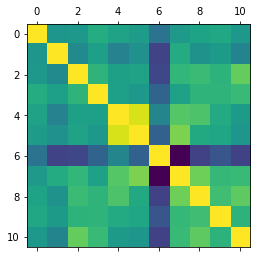

In [12]:
plt.matshow(df.corr())

Now that we have some overall statistics for the data, what does the data look like when all columns are plotted against each other?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c56b9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10edfd668>]], dtype=object)

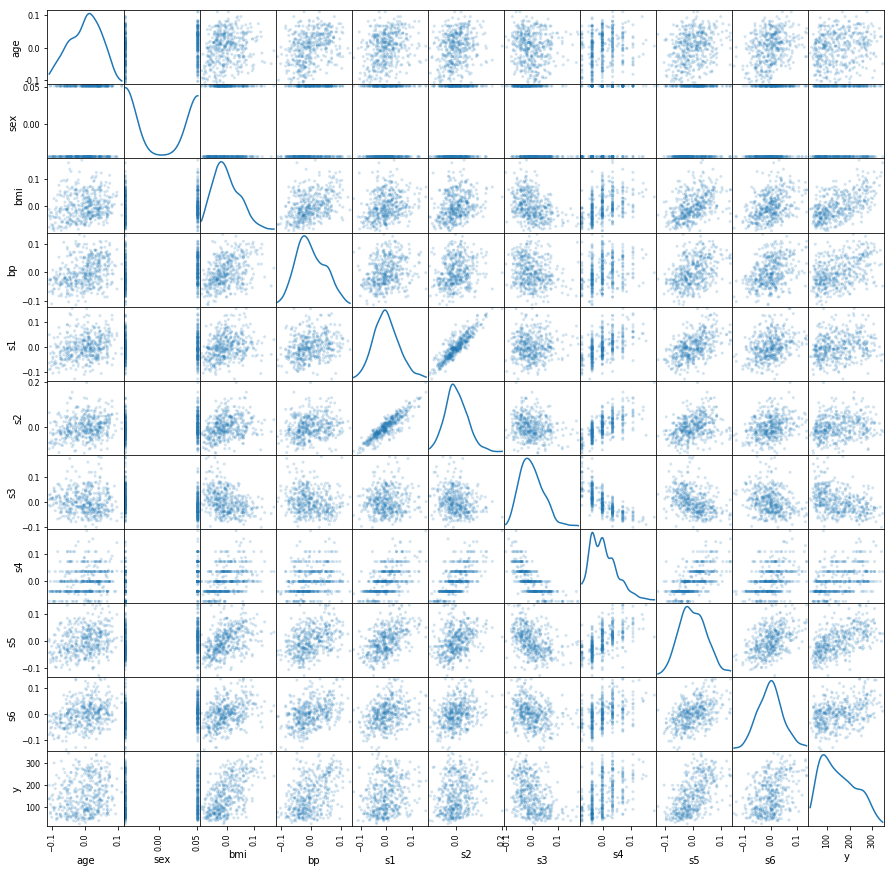

In [13]:
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

`Sex` unsurprisingly falls onto one of two values, but the interesting feature here is `s4` which has a banding effect. The feature `s3` is the only feature negatively correlated with the other features, especially with `s4`

Looking at how the features plotted with the target (y) there is a very loose overall positive correlation by eye. Is there any actual correlation quantitatively:

In [14]:
df.corr(method='pearson')

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


In [15]:
df.corr(method='spearman') 

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
age,1.000000,0.177463,0.200554,0.350859,0.262524,0.221711,-0.106973,0.221017,0.265176,0.296235,0.197822
sex,0.177463,1.000000,0.098079,0.261508,0.027790,0.134695,-0.394584,0.337524,0.174625,0.203277,0.037401
bmi,0.200554,0.098079,1.000000,0.397985,0.287829,0.295494,-0.371172,0.459068,0.491609,0.384664,0.561382
bp,0.350859,0.261508,0.397985,1.000000,0.275224,0.205638,-0.191033,0.280799,0.396071,0.381219,0.416241
s1,0.262524,0.027790,0.287829,0.275224,1.000000,0.878793,0.015308,0.520674,0.512864,0.332173,0.232429
s2,0.221711,0.134695,0.295494,0.205638,0.878793,1.000000,-0.197435,0.652283,0.349947,0.286483,0.195834
s3,-0.106973,-0.394584,-0.371172,-0.191033,0.015308,-0.197435,1.000000,-0.789694,-0.450420,-0.290863,-0.410022
s4,0.221017,0.337524,0.459068,0.280799,0.520674,0.652283,-0.789694,1.000000,0.640390,0.413700,0.448931
s5,0.265176,0.174625,0.491609,0.396071,0.512864,0.349947,-0.450420,0.640390,1.000000,0.453023,0.589416
s6,0.296235,0.203277,0.384664,0.381219,0.332173,0.286483,-0.290863,0.413700,0.453023,1.000000,0.350792


Overall there is a positive correlation but not a strong one. `S3` is the only feature to have a negative correlation with the target.

Let's see if there is any visual separation of the data by `sex`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fbb4860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1130d3240>]], dtype=object)

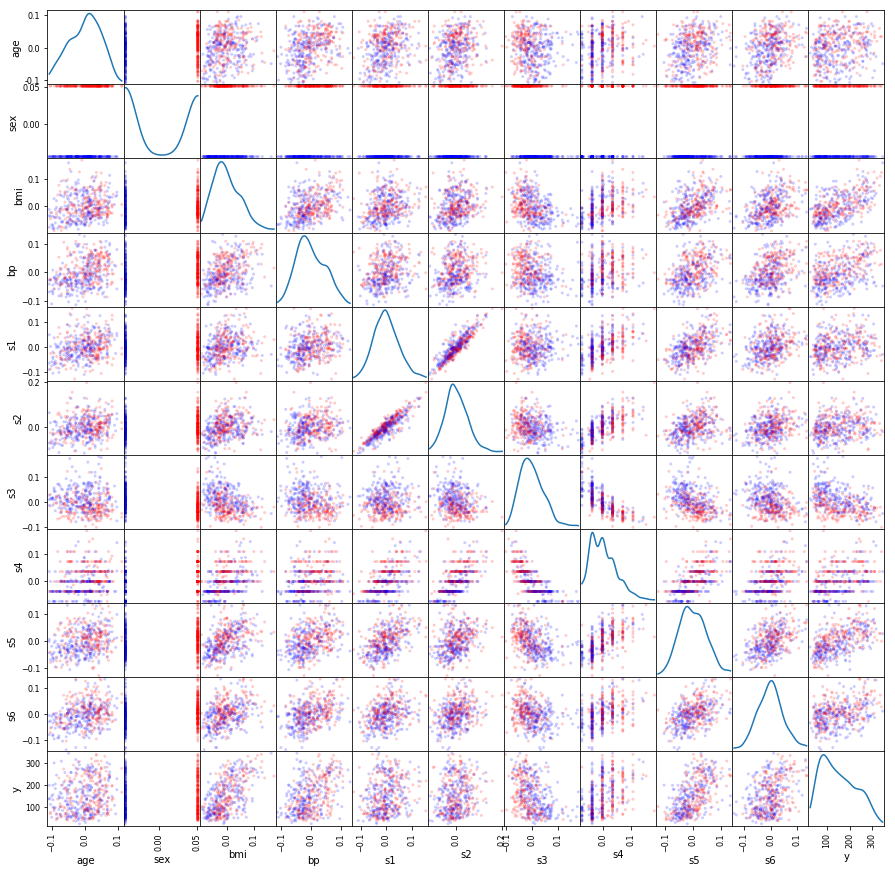

In [16]:
colours = ['red' if i > 0 else 'blue' for i in df['sex']]
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde', color=colours)

Not really any visual separation by gender

## Models

Seeing that the target is numerical we have a regression task on our hands. The first thing to do is to pick the metric used to assess the quality of the model, here I've chosen to use root mean squared error which is a common metric to use with regression tasks.

I will take a look at 4 types of regression here: linear regression, lasso regression, ridge regression and elastic net regression.

In [17]:
# Make a training and test set
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, random_state=42, shuffle=True)

### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

/Users/harpalsahota/.virtualenvs/DataScience/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# Make the predictions on the test set
pred = lr.predict(X_test)
print(np.sqrt(mean_squared_error(pred, y_test)))

53.369422968


An RMSE of 53 is not great, but its not bad either considering how weak the correlations are with the target

### Lasso Regression

In [21]:
from sklearn.linear_model import Lasso

Starting with a conservative `alpha` of 1 let's train a `Lasso` model. I will experiment with different alphas later.

In [22]:
lasso_reg = Lasso(alpha=1, fit_intercept=True)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
lasso_reg.coef_

array([   0.        ,   -0.        ,  398.38436775,   46.17884277,
          0.        ,    0.        ,   -0.        ,    0.        ,
        238.18740159,    0.        ])

wow, 3 out of 10 features are non-zero! The model thinks only 3 features are important with an `alpha` set to 1

What do the predictions look like:

In [24]:
pred_lasso = lasso_reg.predict(X_test)
print(np.sqrt(mean_squared_error(pred_lasso, y_test)))

58.5931093116


58.59, not bad, worse that linear regression, but we have room to manoeuvre with the `alpha` parameter

Out of curiosity, how do the coefficients for each feature change when alpha is changed:

In [25]:
import numpy as np

In [26]:
n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)

coefs = []
for a in alphas:
    lasso_reg_vary_alpha = Lasso(alpha=a, fit_intercept=True)
    lasso_reg_vary_alpha.fit(dataset.data, dataset.target)
    coefs.append(lasso_reg_vary_alpha.coef_)

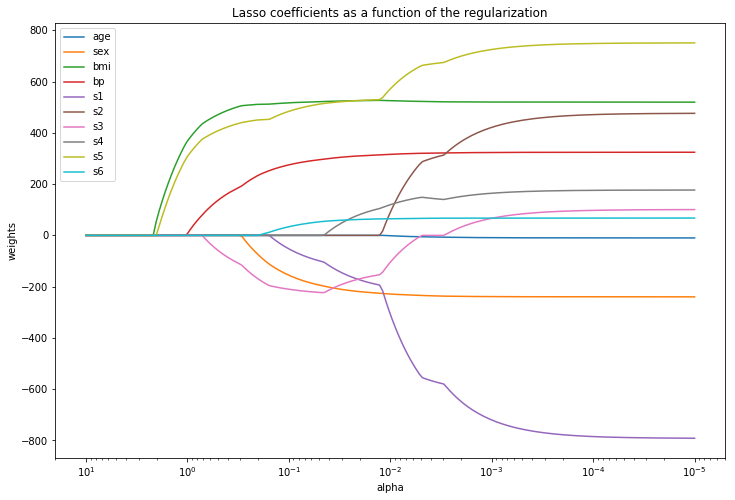

In [27]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.legend([i for i in df.columns[:-1]])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


They vary a lot, with a high `alpha` value the coefficients are heavily constrained which is why only 3 features have a non-zero value when `alpha` is 1. Reducing `alpha` loosens these constraints allowing the coefficients to change more freely. As you can see with a decreasing alpha more coefficients become non-zero with only `age` remaining at zero. This gives us an insight that `age` may not be a useful feature at it may have to be removed.

### Ridge Regression

In [28]:
from sklearn.linear_model import Ridge

How does ridge regression perform?

In [29]:
ridge_reg = Ridge(alpha=1, fit_intercept=True)
ridge_reg.fit(X_train, y_train)
ridge_reg.coef_

array([  50.55155508,  -67.72236516,  278.3007281 ,  197.62401363,
         -6.2459735 ,  -26.22698465, -151.39451804,  120.32319558,
        215.85469359,  101.75554294])

In [30]:
pred_ridge = ridge_reg.predict(X_test)
print(np.sqrt(mean_squared_error(pred_ridge, y_test)))

55.726732821


Falls in-between linear regression and lasso, but like lasso, we can play with the `alpha` to improve performance

Ridge coefficients with varying `alpha`:

In [31]:
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

coefs = []
for a in alphas:
    ridge_reg_vary_alpha = Ridge(alpha=a, fit_intercept=True)
    ridge_reg_vary_alpha.fit(dataset.data, dataset.target)
    coefs.append(ridge_reg_vary_alpha.coef_)

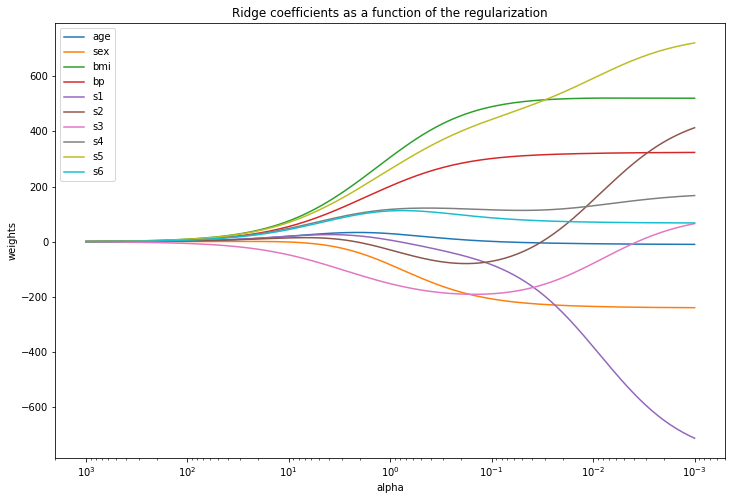

In [32]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.legend([i for i in df.columns[:-1]])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Like lasso, decreasing `alpha` constrains the weights less and non-informative features will be reduced to near zero (which is a subtle difference to lasso). The ridge model also thinks that `age` is not an important feature.

### Elastic Net

In [33]:
from sklearn.linear_model import ElasticNet

Next up elastic net:

In [40]:
en = ElasticNet(alpha=1, l1_ratio=0.5, fit_intercept=True, random_state=42)
en.fit(X_train, y_train)
en.coef_

array([ 0.41308763,  0.        ,  3.29899112,  2.25693877,  0.33937965,
        0.08078391, -1.87466133,  2.1438686 ,  2.94796429,  1.70198081])

In [41]:
pred_en = en.predict(X_test)
print(np.sqrt(mean_squared_error(pred_en, y_test)))

74.5267242261


Worst score so far of the three regressions with regularisation.

Elastic Net coefficients with varying alpha:

In [44]:
n_alphas = 200
alphas = np.logspace(-3, 1, n_alphas)

coefs = []
for a in alphas:
    en_reg_vary_alpha = ElasticNet(alpha=a, l1_ratio=0.5, fit_intercept=True, random_state=42)
    en_reg_vary_alpha.fit(dataset.data, dataset.target)
    coefs.append(en_reg_vary_alpha.coef_)

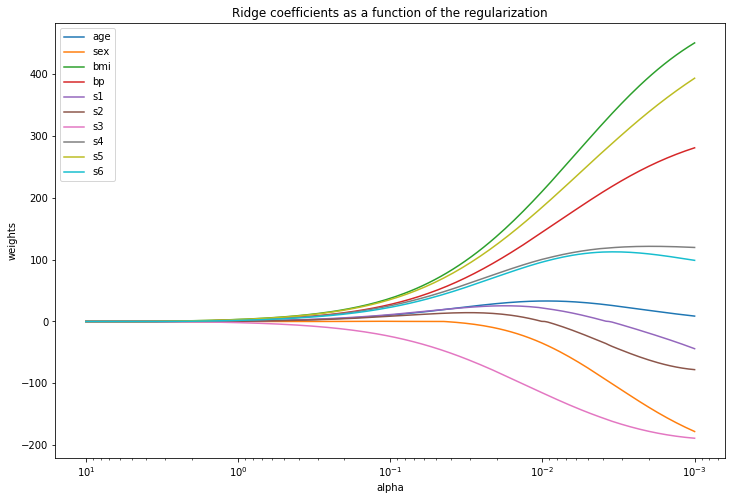

In [45]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.legend([i for i in df.columns[:-1]])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Elastic net also seems to think age may not be a relevant feature

### Quick Polynomial Features

Sometimes introducing polynomial features can improve performance especially when the data is not linearly related to the target. From initial plots, it looks like the data is more roughly linearly related, so I would suspect introducing polynomial features to hinder performance. This is being investigated to confirm this is the case:

In [46]:
from sklearn.preprocessing import PolynomialFeatures

In [47]:
# Keep it simple and make polynomial features to the degree of 2
poly_feats = PolynomialFeatures(degree=2, include_bias=False)

In [50]:
# Make the polynomial features
X_poly = poly_feats.fit_transform(dataset.data)

In [51]:
# Split the data into train and test sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, dataset.target, random_state=42, shuffle=True, test_size=0.2)

Running a linear regression to see impact on performance:

In [54]:
# Linear regression with polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)
pred_poly = lr_poly.predict(X_test_poly)
np.sqrt(mean_squared_error(pred_poly, y_test_poly))

55.639689843249727

Slightly worse performance compared to no polynomial features

Let's take a quick look at Lasso as well:

In [55]:
# Lasso with polynomial features
lasso_reg_poly = Lasso(alpha=1, fit_intercept=True)
lasso_reg_poly.fit(X_train_poly,y_train_poly)
lasso_pred_poly = lasso_reg_poly.predict(X_test_poly)
np.sqrt(mean_squared_error(lasso_pred_poly, y_test_poly))

58.340125059144178

A slight improvement of approximately 0.5

What do the coefficients look like:

In [56]:
lasso_reg_poly.coef_

array([   0.        ,   -0.        ,  413.4304682 ,   34.83548263,
          0.        ,    0.        ,   -0.        ,    0.        ,
        258.15143648,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,   -0.        ,   -0.        ,
         -0.        ,    0.        ,    0.        ,    0.        ,
         -0.        ,    0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   -0.        ,
         -0.        ,   -0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   -0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
         -0.        ,   -0.        ,   -0.        ,    0.        ,
         -0.        ,    0.        ,   -0.        ,    0.        ,
         -0.        ,   -0.        ,   -0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        ,    0.     

Interesting, all of the polynomial features have been shrunk to zero (although alpha is high). Only the original features are non-zero (index <=9). Even though we saw it a slight improvement in the performance of the model, I initially thought it was due to the polynomial features! Only when I looked at the coefficients did I see they were reduced to zero. From here on, I will discard the polynomial features and only use the features provided with the dataset.

### TODO
- Lasso CV
- Learning Curve


In [43]:
from sklearn.model_selection import GridSearchCV

In [47]:
n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)

In [51]:
data = df[['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']]
target = df['y']

In [52]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_gs = KFold(n_splits=5, random_state=42, shuffle=True)

In [76]:
for train_index, test_index in cv.split(data):
    validation_set_y = target.iloc[test_index]
    validation_set_x = data.iloc[test_index]
    training_set_x = data.iloc[train_index]    
    training_set_y = target.iloc[train_index]
    
    lasso_reg = Lasso(fit_intercept=False)
    gs = GridSearchCV(
        lasso_reg,
        {
            'alpha': alphas,
        },
        scoring='neg_mean_squared_error',
        cv=cv_gs
    )
    gs.fit(training_set_x, training_set_y)
    val_set_pred = gs.predict(validation_set_x)
    print(mean_squared_error(validation_set_y, val_set_pred), np.sqrt(mean_squared_error(validation_set_y, val_set_pred)))

26354.915271 162.341970146
29221.5154102 170.943018021
26885.5436035 163.968117643
27719.1937859 166.490821927
25274.4827911 158.979504312


In [80]:
for train_index, test_index in cv.split(data):
    validation_set_y = target.iloc[test_index]
    validation_set_x = data.iloc[test_index]
    training_set_x = data.iloc[train_index]    
    training_set_y = target.iloc[train_index]
    
    lr = LinearRegression()
    lr.fit(training_set_x, training_set_y)

    pred = lr.predict(validation_set_x)
    print(mean_squared_error(validation_set_y, pred), np.sqrt(mean_squared_error(validation_set_y, pred)))

2900.17328788 53.8532569849
2662.63714463 51.6007475201
3312.2661155 57.5522902715
2797.92365858 52.8954030005
3403.87291807 58.342719495


plain linear regression performs much better than lasso

In [83]:
from sklearn.linear_model import Ridge

In [86]:
ridge_reg = Ridge(alpha=0.0, fit_intercept=False)
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)
print(mean_squared_error(pred, y_test), np.sqrt(mean_squared_error(pred, y_test)))

27317.1592477 165.279034507
